#### Описание задачи

Цель: построить модель машинного обучения для предсказания успешности стартапа на основе входных данных

#### Чтение данных

In [1393]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [1394]:
data = pd.read_csv('./startup_data.csv')
data

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,352,CA,37.740594,-122.376471,94107,c:21343,San Francisco,NaN,CoTweet,1,...,c:21343,0,0,1,0,0,0,6.0000,1,acquired
919,721,MA,42.504817,-71.195611,1803,c:41747,Burlington,Burlington MA 1803,Reef Point Systems,0,...,c:41747,1,0,0,1,0,0,2.6667,1,closed
920,557,CA,37.408261,-122.015920,94089,c:31549,Sunnyvale,NaN,Paracor Medical,0,...,c:31549,0,0,0,0,0,1,8.0000,1,closed
921,589,CA,37.556732,-122.288378,94404,c:33198,San Francisco,NaN,Causata,1,...,c:33198,0,0,1,1,0,0,1.0000,1,acquired


In [1395]:
# Drop specified columns
columns_to_drop = ['id', 'Unnamed: 0', 'Unnamed: 6', 'closed_at', 
                   'state_code.1', 'labels', 'zip_code', 'longitude', 
                   'latitude', 'object_id', 'founded_at','first_funding_at',
                   'last_funding_at','city','name' ]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Check the new structure of the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state_code                923 non-null    object 
 1   age_first_funding_year    923 non-null    float64
 2   age_last_funding_year     923 non-null    float64
 3   age_first_milestone_year  771 non-null    float64
 4   age_last_milestone_year   771 non-null    float64
 5   relationships             923 non-null    int64  
 6   funding_rounds            923 non-null    int64  
 7   funding_total_usd         923 non-null    int64  
 8   milestones                923 non-null    int64  
 9   is_CA                     923 non-null    int64  
 10  is_NY                     923 non-null    int64  
 11  is_MA                     923 non-null    int64  
 12  is_TX                     923 non-null    int64  
 13  is_otherstate             923 non-null    int64  
 14  category_c

In [1396]:
# Кол-во приобритенных и закрытых стартапов
print(data[(data['status']=='acquired')].shape)
print(data[(data['status']=='closed')].shape)

(597, 34)
(326, 34)


In [1397]:
# Замена значений в столбце 'status
data['status'] = data['status'].replace({'acquired':1, 'closed':0})

C:\Users\emilg\AppData\Local\Temp\ipykernel_14572\3621226073.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['status'] = data['status'].replace({'acquired':1, 'closed':0})


In [1398]:
# Откидываем дубликаты
print("Before dropping duplicates: {}".format(len(data)))
data.drop_duplicates(inplace=True)
print("After ropping duplicates: {}".format(len(data)))


Before dropping duplicates: 923
After ropping duplicates: 922


In [1399]:
columns_to_check = ['age_first_funding_year', 'age_last_funding_year', 
                    'age_first_milestone_year', 'age_last_milestone_year']
for col in columns_to_check:
    data[col] = data[col].apply(lambda x: x if x >= 0 else np.nan)


**Опишем некоторые данные**
- state_code - Код штата, в котором зарегистрирован стартап.

- status - Текущий статус стартапа (0 - закрыт, 1 - выкуплен).

- age_first_funding_year - Возраст стартапа в годах на момент получения первого финансирования.

- age_last_funding_year - Возраст стартапа в годах на момент получения последнего финансирования.

- age_first_milestone_year - Возраст стартапа в годах на момент достижения первой вехи.

- age_last_milestone_year - Возраст стартапа в годах на момент достижения последней вехи.

- relationships - Количество связей или контактов, которые имеет стартап (например, количество партнеров или инвесторов).

- funding_rounds - Общее количество раундов финансирования, в которых участвовал стартап.

- funding_total_usd - Общая сумма финансирования в долларах США, полученная стартапом.

- milestones - Данные о ключевых вехах, достигнутых стартапом (например, завершение разработки продукта, получение финансирования и т.д.).

- category_code - Код категории, к которой относится стартап (например, технологии, здравоохранение, финансы и т.д.).

- has_VC - Булевый признак, указывающий на наличие венчурного капитала среди инвесторов стартапа.

- has_angel - Булевый признак, указывающий на наличие ангельских инвесторов среди инвесторов стартапа.

- avg_participants - Среднее количество участников в раундах финансирования.

- is_top500 - Булевый признак, указывающий на то, входит ли стартап в список 500 лучших стартапов.

In [1400]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 922 entries, 0 to 922
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state_code                922 non-null    object 
 1   age_first_funding_year    876 non-null    float64
 2   age_last_funding_year     909 non-null    float64
 3   age_first_milestone_year  724 non-null    float64
 4   age_last_milestone_year   758 non-null    float64
 5   relationships             922 non-null    int64  
 6   funding_rounds            922 non-null    int64  
 7   funding_total_usd         922 non-null    int64  
 8   milestones                922 non-null    int64  
 9   is_CA                     922 non-null    int64  
 10  is_NY                     922 non-null    int64  
 11  is_MA                     922 non-null    int64  
 12  is_TX                     922 non-null    int64  
 13  is_otherstate             922 non-null    int64  
 14  category_code  

#### Визиулизацуя данных

In [1401]:
data_num=data.select_dtypes(include=np.number) # только числовые данные
data_num

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,1,0,...,1,0,1,0,0,0,0,1.0000,0,1
1,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,1,0,...,0,1,0,0,1,1,1,4.7500,1,1
2,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,1,0,...,0,0,0,1,0,0,0,4.0000,1,1
3,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,1,0,...,0,0,0,0,1,1,1,3.3333,1,1
4,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,1,0,...,0,1,1,0,0,0,0,1.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,1,0,...,0,0,0,1,0,0,0,6.0000,1,1
919,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,0,0,...,1,1,0,0,1,0,0,2.6667,1,0
920,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,1,0,...,0,0,0,0,0,0,1,8.0000,1,0
921,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,1,0,...,0,0,0,1,1,0,0,1.0000,1,1


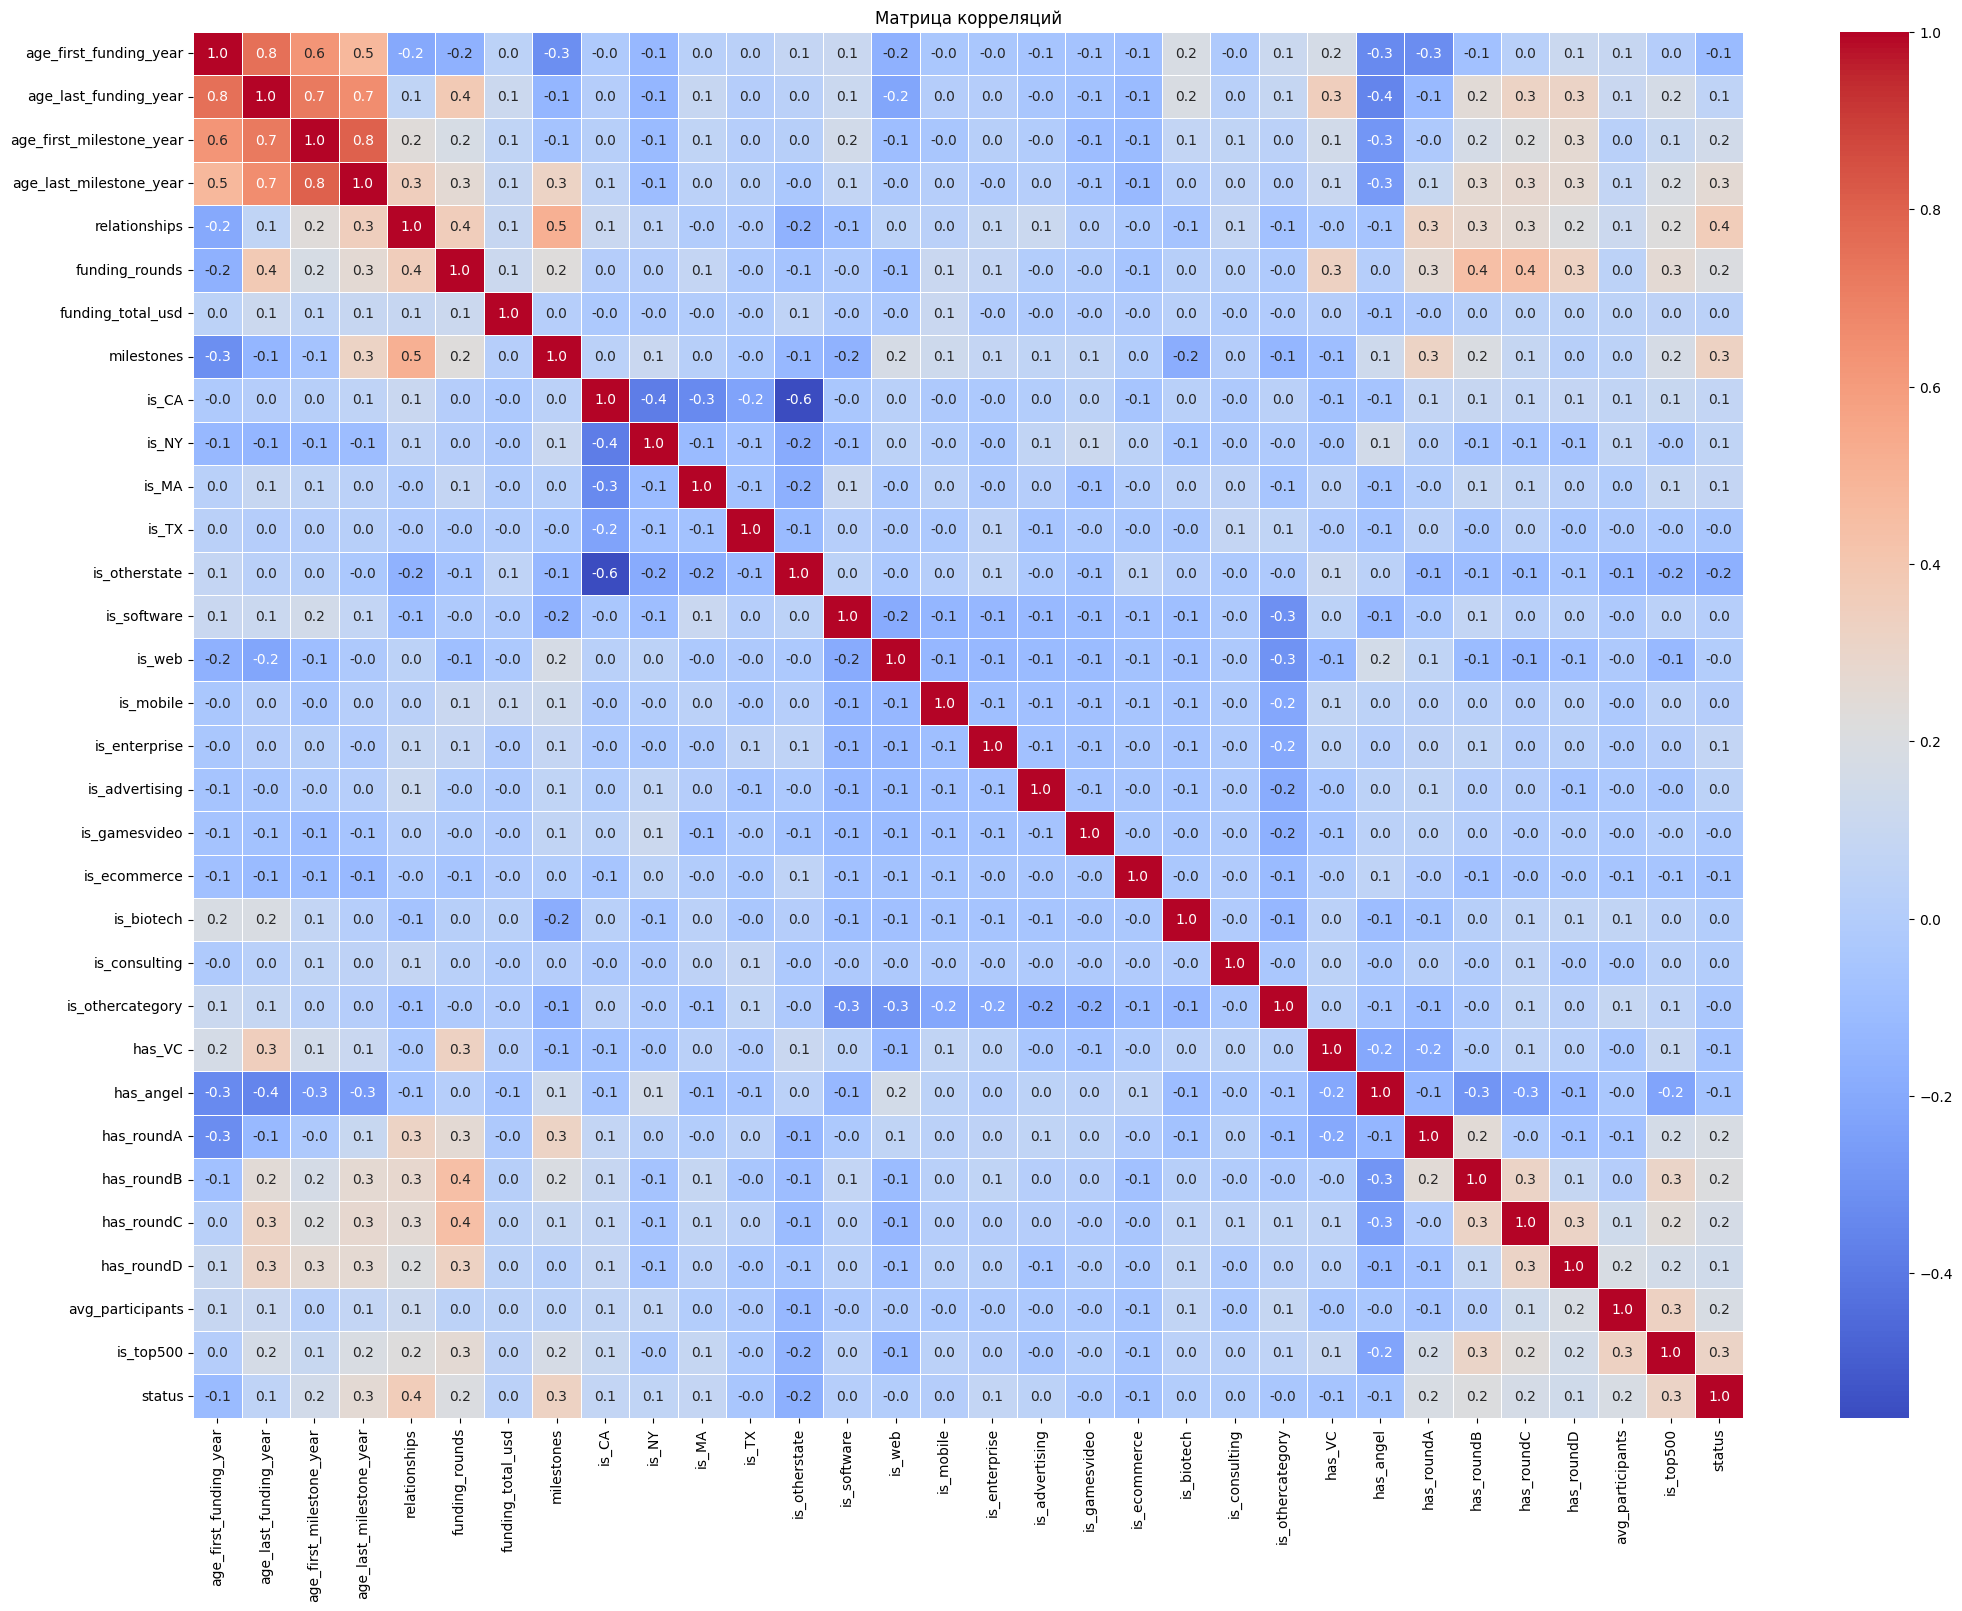

In [1402]:
plt.figure(figsize = (25, 18))
heat_map = data.corr(numeric_only=True) 
sns.heatmap(heat_map, annot = True, cmap = 'coolwarm', linewidth = 0.5, fmt = '.1f')
                         # annot добавл. числовые значения к каждой ячейке   fmt = 1 знак после запятой
plt.title('Матрица корреляций')
plt.show()

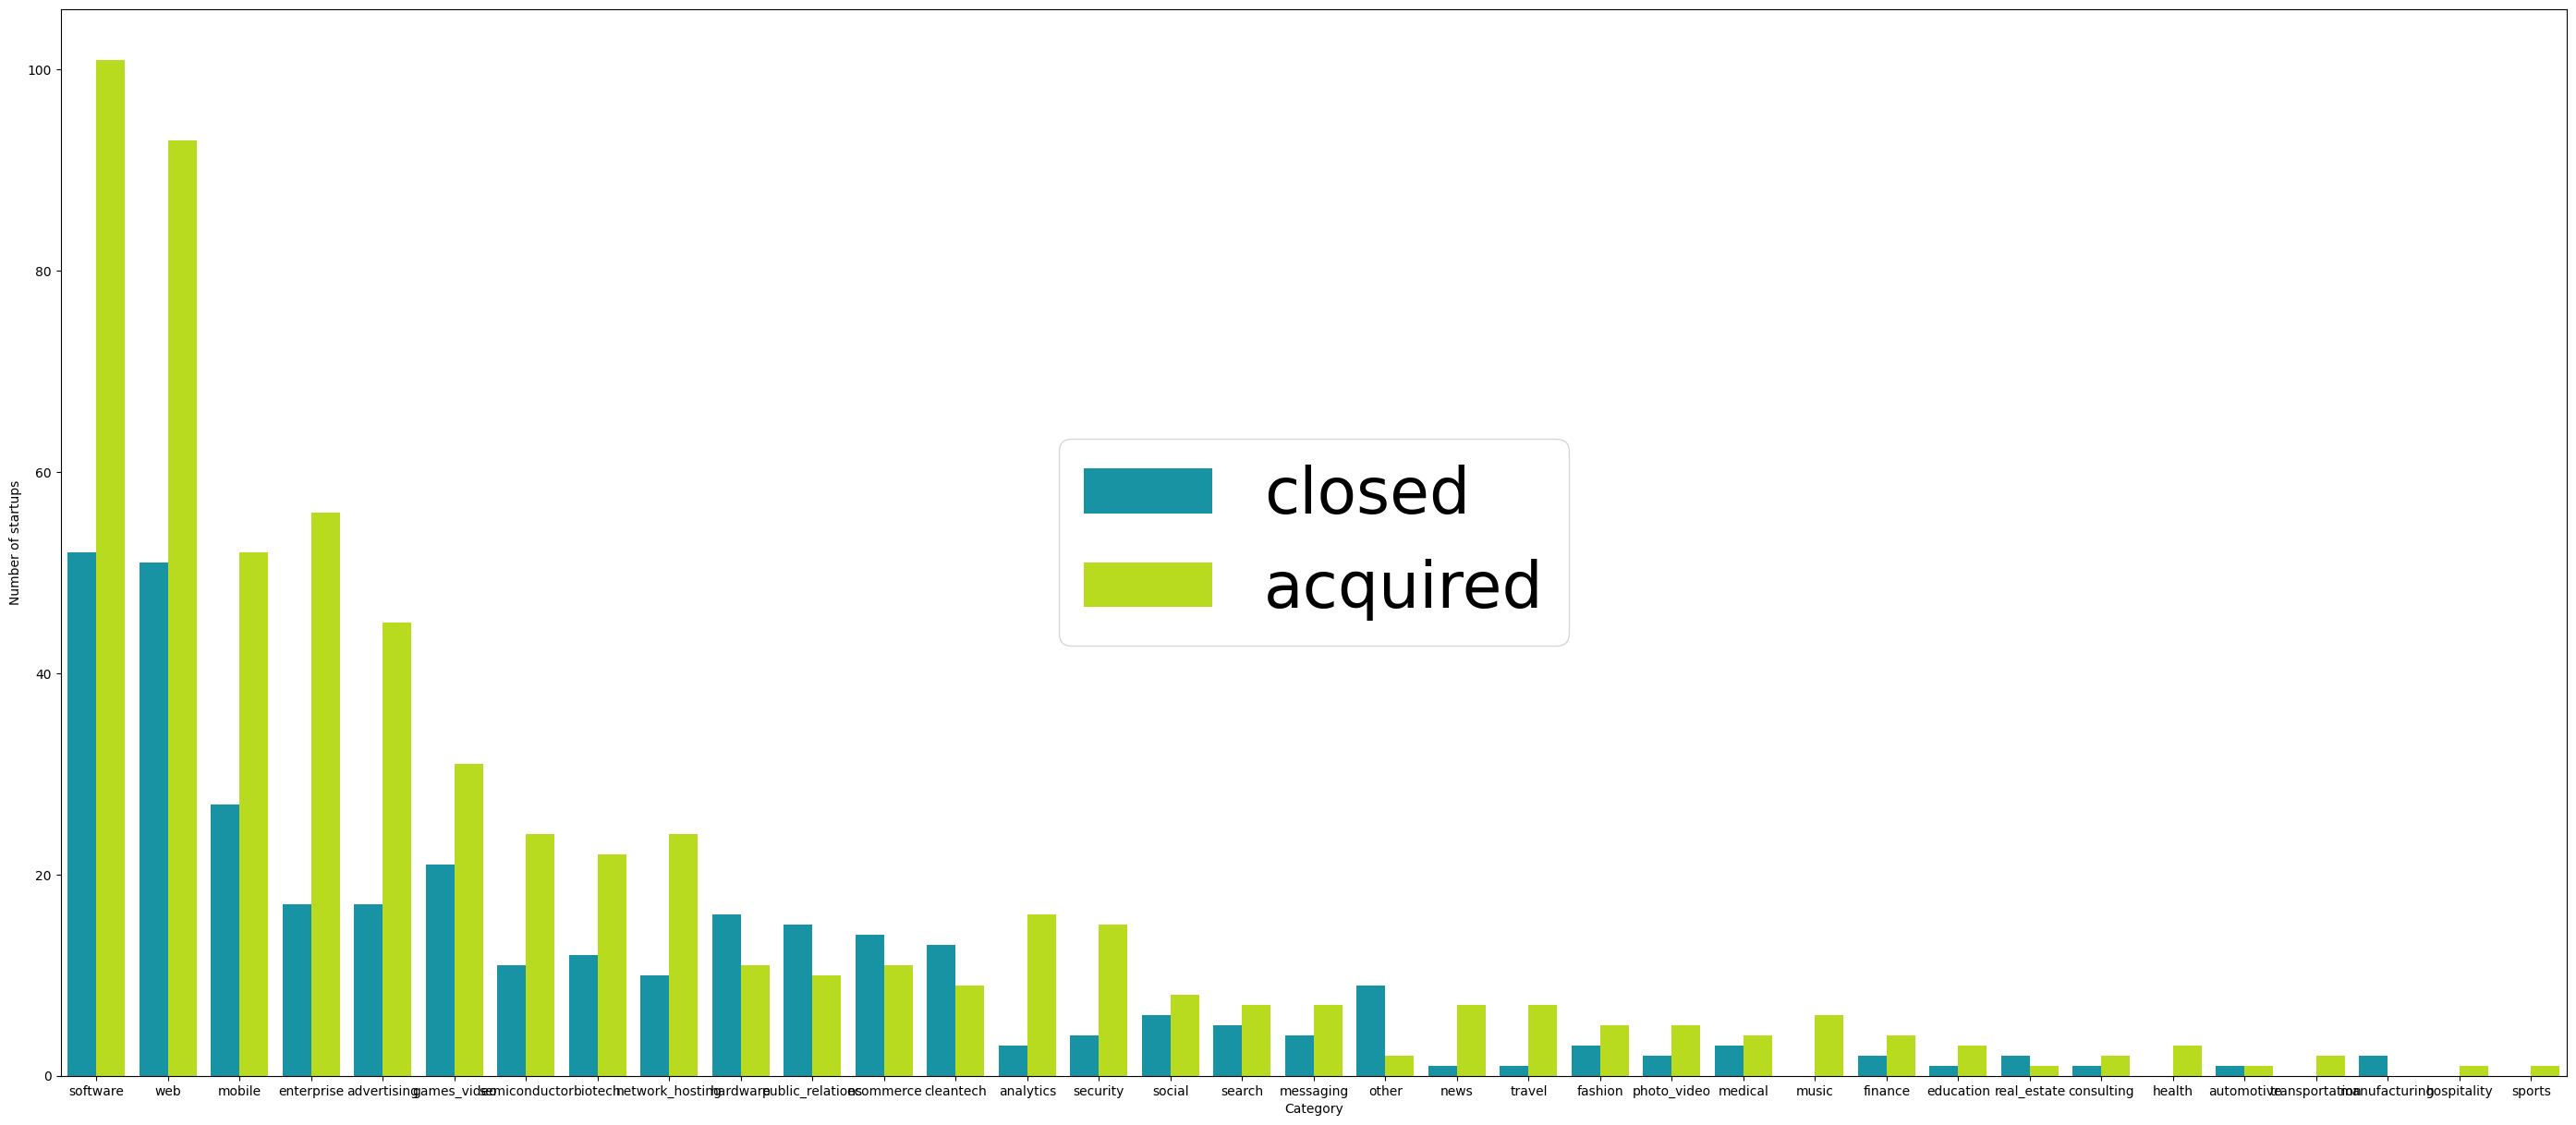

In [1403]:
#  Визуального сравнение количества стартапов в разных категориях в зависимости от их статуса
fig,ax = plt.subplots(figsize=(35,15))

plot = sns.countplot(x='category_code',hue='status', palette = "nipy_spectral", data=data, order= data['category_code'].value_counts().index)
plot = ax.set(xlabel="Category", ylabel="Number of startups")
plt.legend(loc = "center", fontsize = 50, labels = ['closed', 'acquired'])

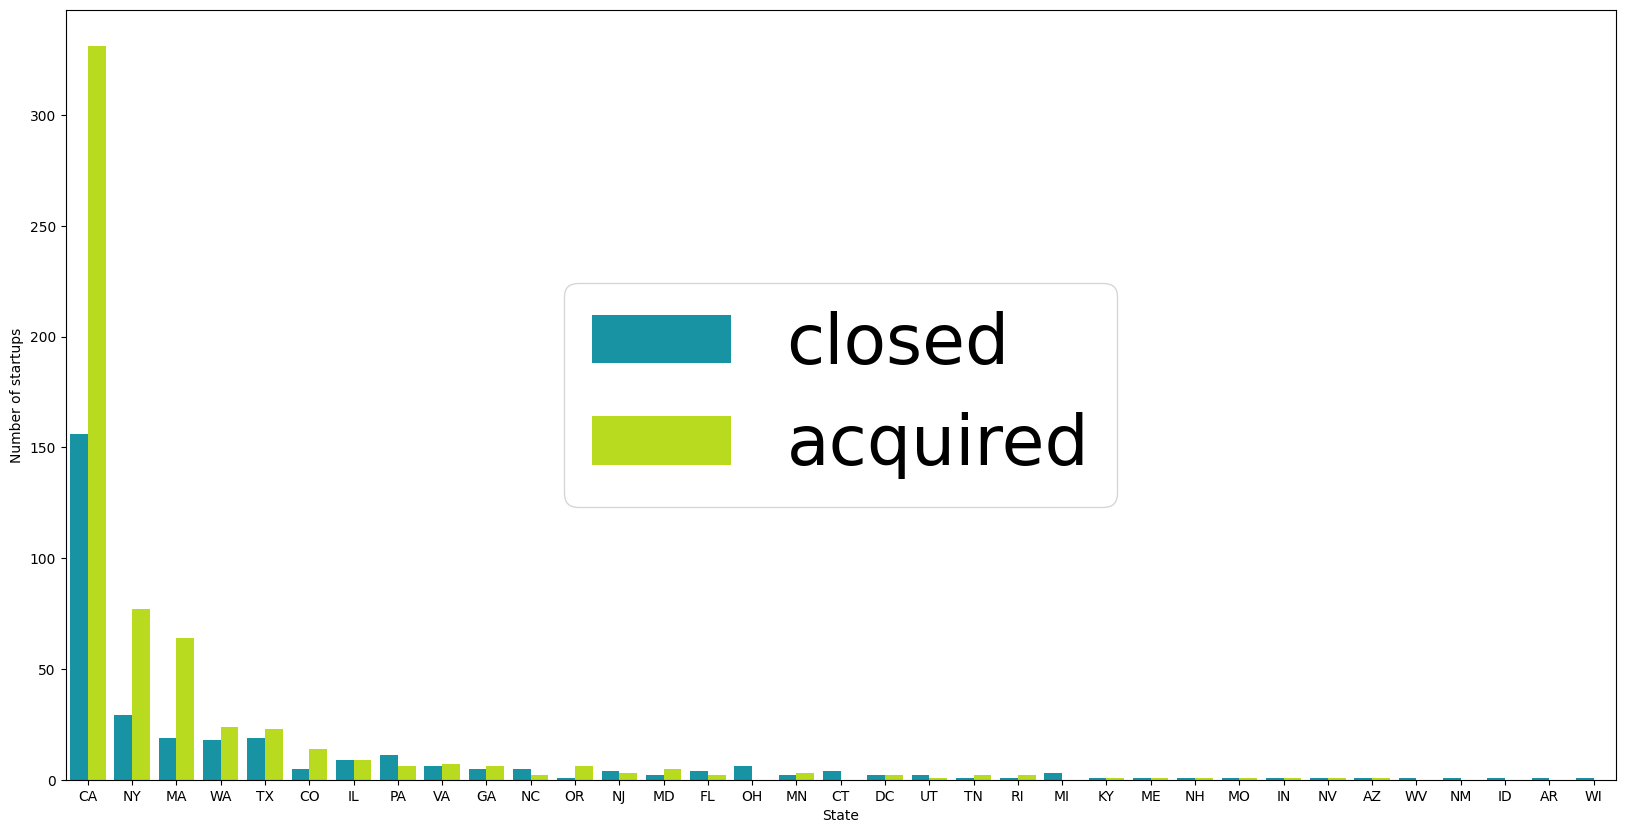

In [1404]:
#  Визуального сравнение количества стартапов в разных категориях в зависимости от их штата
fig,ax = plt.subplots(figsize=(20,10))

plot = sns.countplot(x='state_code',hue='status', palette = "nipy_spectral", data=data, order= data['state_code'].value_counts().index)
plot = ax.set(xlabel="State", ylabel="Number of startups")
plt.legend(loc = "center", fontsize = 50, labels = ['closed', 'acquired'])

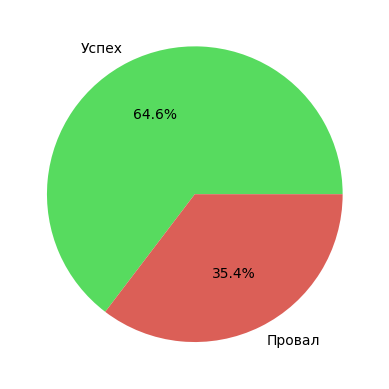

In [1405]:
# распределение целевой переменной status
plt.pie(data['status'].value_counts(), labels = ['Успех', 'Провал'],  colors=sns.color_palette('hls')[2::-2], autopct='%.1f%%')
plt.show()

In [1406]:
data.describe()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
count,876.000000,909.000000,724.000000,758.000000,922.000000,922.000000,9.220000e+02,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.00000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,2.390879,4.003294,3.341554,4.862970,7.703905,2.309111,2.541017e+07,1.841649,0.527115,0.114967,...,0.322126,0.325380,0.254881,0.507592,0.39154,0.232104,0.099783,2.839225,0.809111,0.646421
std,2.462186,2.914274,2.777031,3.112599,7.266762,1.390562,1.897371e+08,1.323340,0.499535,0.319156,...,0.467545,0.468771,0.436031,0.500214,0.48836,0.422404,0.299873,1.875518,0.393215,0.478340
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.676700,1.816400,1.184925,2.528050,3.000000,1.000000,2.712500e+06,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.500000,1.000000,0.000000
50%,1.634250,3.569900,2.857550,4.521900,5.000000,2.000000,1.000000e+07,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,2.500000,1.000000,1.000000
75%,3.690425,5.583600,5.002700,6.786325,10.000000,3.000000,2.465264e+07,3.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,3.800000,1.000000,1.000000
max,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,5.700000e+09,8.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,16.000000,1.000000,1.000000


#### Обработка пропущенных значений

In [1407]:
data.isnull().sum()

state_code                    0
age_first_funding_year       46
age_last_funding_year        13
age_first_milestone_year    198
age_last_milestone_year     164
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_gamesvideo                 0
is_ecommerce                  0
is_biotech                    0
is_consulting                 0
is_othercategory              0
has_VC                        0
has_angel                     0
has_roundA                    0
has_roundB                    0
has_roundC                    0
has_roundD                    0
avg_part

In [1408]:
data.dropna(axis=1, inplace=True)
data.isnull().sum()

state_code           0
relationships        0
funding_rounds       0
funding_total_usd    0
milestones           0
is_CA                0
is_NY                0
is_MA                0
is_TX                0
is_otherstate        0
category_code        0
is_software          0
is_web               0
is_mobile            0
is_enterprise        0
is_advertising       0
is_gamesvideo        0
is_ecommerce         0
is_biotech           0
is_consulting        0
is_othercategory     0
has_VC               0
has_angel            0
has_roundA           0
has_roundB           0
has_roundC           0
has_roundD           0
avg_participants     0
is_top500            0
status               0
dtype: int64

#### Обработка категориальных признаков

In [1409]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['state_code'] = le.fit_transform(data['state_code'])
data['category_code'] = le.fit_transform(data['category_code'])


In [1410]:
print(data.dtypes)

state_code             int64
relationships          int64
funding_rounds         int64
funding_total_usd      int64
milestones             int64
is_CA                  int64
is_NY                  int64
is_MA                  int64
is_TX                  int64
is_otherstate          int64
category_code          int64
is_software            int64
is_web                 int64
is_mobile              int64
is_enterprise          int64
is_advertising         int64
is_gamesvideo          int64
is_ecommerce           int64
is_biotech             int64
is_consulting          int64
is_othercategory       int64
has_VC                 int64
has_angel              int64
has_roundA             int64
has_roundB             int64
has_roundC             int64
has_roundD             int64
avg_participants     float64
is_top500              int64
status                 int64
dtype: object


In [1411]:
data['state_code'].unique()

array([ 2, 12, 11, 23,  3, 31, 29, 32,  9, 18, 26,  7, 19, 17,  6, 20, 34,
       15,  5,  4, 13, 24, 28, 16, 27, 25, 30, 14, 22, 21, 10,  1,  8,  0,
       33])

In [1412]:
data['category_code'].unique()

array([19,  8, 34, 30, 11, 20, 10, 18,  7, 24, 27, 22, 23, 12,  6,  0, 33,
        9,  1,  5,  3,  4, 26, 28, 29, 16,  2, 17, 15, 14, 21, 32, 31, 25,
       13])

#### Нормализуем данные

In [1413]:
data.describe()

,state_code,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
count,922.000000,922.000000,922.000000,9.220000e+02,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.00000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,10.328633,7.703905,2.309111,2.541017e+07,1.841649,0.527115,0.114967,0.090022,0.045553,0.221258,...,0.322126,0.325380,0.254881,0.507592,0.39154,0.232104,0.099783,2.839225,0.809111,0.646421
std,10.708223,7.266762,1.390562,1.897371e+08,1.323340,0.499535,0.319156,0.286368,0.208627,0.415319,...,0.467545,0.468771,0.436031,0.500214,0.48836,0.422404,0.299873,1.875518,0.393215,0.478340
min,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,3.000000,1.000000,2.712500e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.500000,1.000000,0.000000
50%,2.000000,5.000000,2.000000,1.000000e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,2.500000,1.000000,1.000000
75%,23.000000,10.000000,3.000000,2.465264e+07,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,3.800000,1.000000,1.000000
max,34.000000,63.000000,10.000000,5.700000e+09,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,16.000000,1.000000,1.000000


In [1414]:
# Найдем бинарные столбцы (те, где всего два уникальных значения: 0 и 1)
binary_cols = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]

# Найдем все числовые столбцы
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# Исключим бинарные столбцы из числовых
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

# Выведем результаты
print("Бинарные столбцы:", binary_cols)
print("Числовые столбцы (без бинарных):", numeric_cols)


Бинарные столбцы: ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'is_top500', 'status']
Числовые столбцы (без бинарных): ['state_code', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'category_code', 'avg_participants']


In [1415]:
data[numeric_cols] = (data[numeric_cols] - data[numeric_cols].mean(axis=0)) / data[numeric_cols].std(axis=0)
data.describe()

,state_code,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
count,9.220000e+02,9.220000e+02,9.220000e+02,9.220000e+02,9.220000e+02,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.00000,922.000000,922.000000,9.220000e+02,922.000000,922.000000
mean,1.733971e-17,2.311961e-17,8.573523e-17,-7.706537e-18,-5.779903e-18,0.527115,0.114967,0.090022,0.045553,0.221258,...,0.322126,0.325380,0.254881,0.507592,0.39154,0.232104,0.099783,-2.389027e-16,0.809111,0.646421
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.499535,0.319156,0.286368,0.208627,0.415319,...,0.467545,0.468771,0.436031,0.500214,0.48836,0.422404,0.299873,1.000000e+00,0.393215,0.478340
min,-9.645516e-01,-1.060156e+00,-9.414255e-01,-1.338651e-01,-1.391667e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-9.806488e-01,0.000000,0.000000
25%,-7.777792e-01,-6.473178e-01,-9.414255e-01,-1.196270e-01,-6.360035e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-7.140558e-01,1.000000,0.000000
50%,-7.777792e-01,-3.720921e-01,-2.222919e-01,-8.121856e-02,1.196604e-01,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,-1.808698e-01,1.000000,1.000000
75%,1.183330e+00,3.159723e-01,4.968418e-01,-3.992561e-03,8.753244e-01,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,5.122721e-01,1.000000,1.000000
max,2.210578e+00,7.609455e+00,5.530778e+00,2.990765e+01,4.653644e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,7.017142e+00,1.000000,1.000000


#### Обучающая и тестовая выборки

In [1416]:
from sklearn.model_selection import train_test_split

# 'status' — это целевая переменная
X = data.drop(columns=['status'])  # Все признаки, кроме целевой переменной
y = data['status']                 # Целевая переменная

# Разделение на train и test выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Проверка размеров выборок
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер тренировочной выборки: (691, 29)
Размер тестовой выборки: (231, 29)


In [1417]:
N_train, _ = X_train.shape
N_test, _ = X_test.shape

N_train, N_test

(691, 231)

In [1418]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

#### Метод K ближайших соседей
Попробуем для начала 10 

In [1419]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 10)
model.fit(X_train, y_train)
train_prod = 100 * model.score(X_train, y_train)
test_prod = 100 * model.score(X_test, y_test)
print("Accuracy. Train: {:.2f}%, Test: {:.2f}%".format(train_prod, test_prod))

Accuracy. Train: 76.85%, Test: 71.86%


#### Попробуем найти оптимальное количество соседей

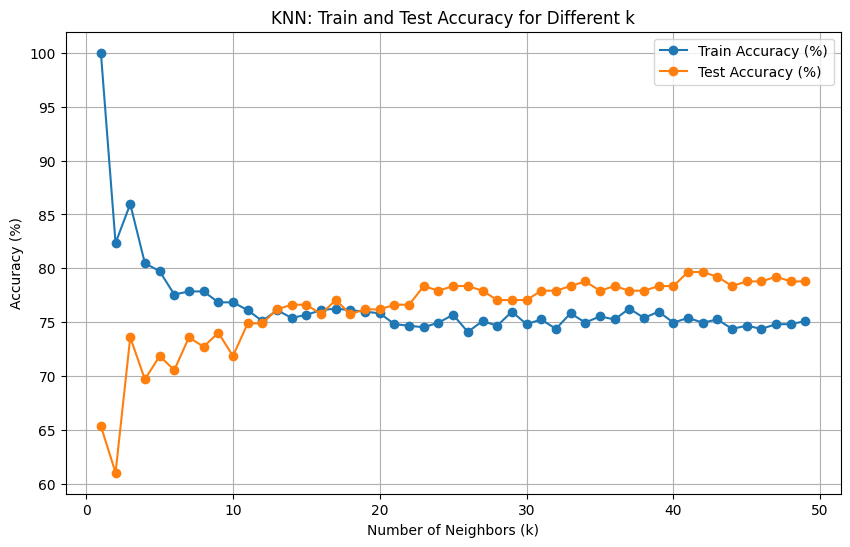

Optimal number of neighbors:  41
Best Test Accuracy: 79.65%
Train Accuracy: 74.96%


In [1420]:
train_accuracy = []
test_accuracy = []

# Диапазон значений для n_neighbors
k_range = range(1, 50)  # Проверяем от 1 до 20 соседей

# Перебираем значения k
for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Оцениваем точность в процентах
    train_accuracy.append(100 * model.score(X_train, y_train))
    test_accuracy.append(100 * model.score(X_test, y_test))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_accuracy, label='Train Accuracy (%)', marker='o')
plt.plot(k_range, test_accuracy, label='Test Accuracy (%)', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy (%)')
plt.title('KNN: Train and Test Accuracy for Different k')
plt.legend()
plt.grid()
plt.show()

# Находим оптимальный k
optimal_k = k_range[test_accuracy.index(max(test_accuracy))]
knn_test_acc = max(test_accuracy)
print("Optimal number of neighbors: ", optimal_k)
print("Best Test Accuracy: {:.2f}%".format(knn_test_acc))
print("Train Accuracy: {:.2f}%".format(train_accuracy[optimal_k]))


#### RandomForest

In [1421]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=42)  
model.fit(X_train, y_train)

train_accuracy = 100 * model.score(X_train, y_train)
test_accuracy = 100 * model.score(X_test, y_test)

print("Accuracy. Train: {:.2f}%, Test: {:.2f}%".format(train_accuracy, test_accuracy))

Accuracy. Train: 99.13%, Test: 78.35%


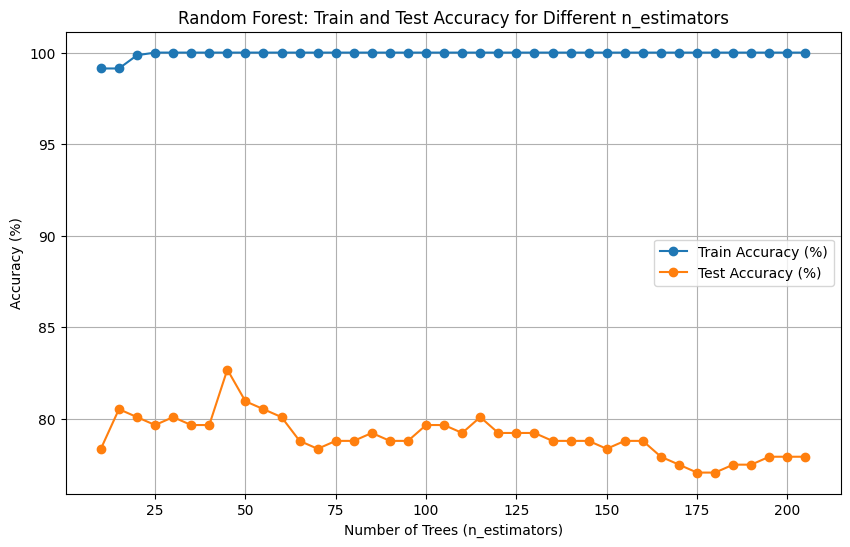

Optimal number of trees:  45
Best Test Accuracy: 82.68%


In [1422]:
train_accuracy = []
test_accuracy = []

# Диапазон количества деревьев
n_estimators_range = range(10, 210, 5)  # Проверяем от 10 до 200 деревьев с шагом 10

# Перебираем количество деревьев
for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    # Оцениваем точность в процентах
    train_accuracy.append(100 * model.score(X_train, y_train))
    test_accuracy.append(100 * model.score(X_test, y_test))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy (%)', marker='o')
plt.plot(n_estimators_range, test_accuracy, label='Test Accuracy (%)', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy (%)')
plt.title('Random Forest: Train and Test Accuracy for Different n_estimators')
plt.legend()
plt.grid()
plt.show()

# Находим оптимальное количество деревьев
optimal_n = n_estimators_range[test_accuracy.index(max(test_accuracy))]
print("Optimal number of trees: ", optimal_n)
print("Best Test Accuracy: {:.2f}%".format(max(test_accuracy)))


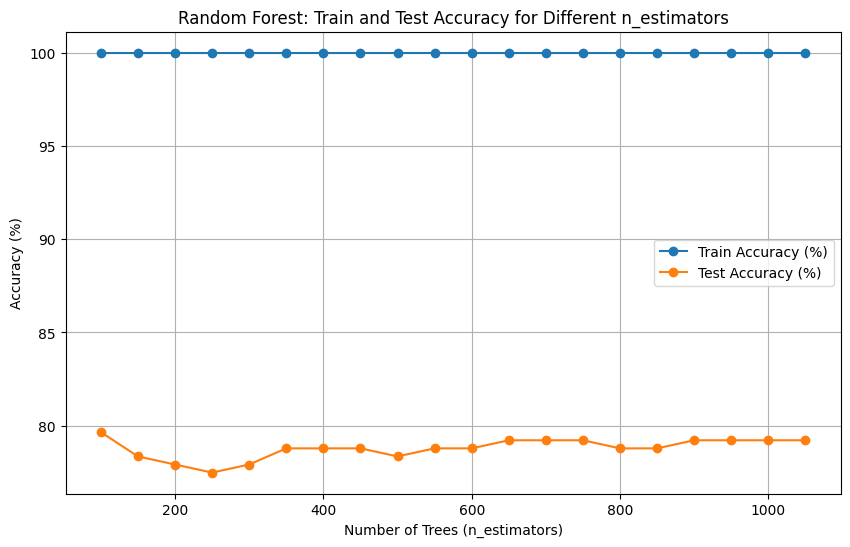

Optimal number of trees:  100
Best Test Accuracy: 79.65%


In [1423]:
train_accuracy = []
test_accuracy = []

# Диапазон количества деревьев
n_estimators_range = range(100, 1100, 50)  # Проверяем от 10 до 200 деревьев с шагом 10

# Перебираем количество деревьев
for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    # Оцениваем точность в процентах
    train_accuracy.append(100 * model.score(X_train, y_train))
    test_accuracy.append(100 * model.score(X_test, y_test))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy (%)', marker='o')
plt.plot(n_estimators_range, test_accuracy, label='Test Accuracy (%)', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy (%)')
plt.title('Random Forest: Train and Test Accuracy for Different n_estimators')
plt.legend()
plt.grid()
plt.show()

# Находим оптимальное количество деревьев
optimal_n = n_estimators_range[test_accuracy.index(max(test_accuracy))]
rf_test_acc = max(test_accuracy)
print("Optimal number of trees: ", optimal_n)
print("Best Test Accuracy: {:.2f}%".format(max(test_accuracy)))


#### Общие выводы по работе

В данной работе была решена задача **классификации успешности стартапов**: "**Будет ли стартап успешным?**".

Для построения и обучения модели классификации использовались два метода:  
- **K-ближайших соседей (KNN)**  
- **Случайный лес (Random Forest)**  

### Подготовка данных

Перед обучением моделей была выполнена тщательная подготовка данных:

1. **Вычисление статистических характеристик**:  
   Проведен анализ данных, включая вычисление среднего, стандартного отклонения, минимальных и максимальных значений для количественных признаков.

2. **Обработка пропущенных значений**:  
   - Выявлены пропущенные значения.  
   - удаляем столбцы с ними.  

3. **Обработка категориальных признаков**:  
   Категориальные признаки были закодированы методом **кодирования меток**.

4. **Нормализация количественных признаков**:  
   Для улучшения работы модели признаки были нормализованы методом **MinMaxScaler**.

5. **Разделение данных на выборки**:  
   - Данные разделены на **обучающую** и **тестовую** выборки в соотношении **75/25**.  
   - Для воспроизводимости результатов использовался параметр `random_state`.

6. **Обучение и оценка моделей**:  
   - Обучены модели **K-ближайших соседей (KNN)** и **Random Forest**.  
   - Оценка качества моделей проведена с использованием метрики **точности (accuracy)**.

### Результаты

По итогам работы:  
- **Random Forest** показал **вышу точность** на тестовой выборке по сравнению с методом **K-ближайших соседей**.  

### Заключение

Таким образом, алгоритм **Random Forest** продемонстрировал лучшие результаты по сравнению с KNN и был признан более эффективным для решения задачи классификации успешности стартапов.
